In [1]:
from random import random, seed

from ipywidgets import interact
from numpy import array, absolute, complex128, cumsum, eye, float64, zeros
from numpy.typing import NDArray
from scipy.sparse.linalg import bicgstab
from matplotlib.pyplot import subplots

%matplotlib widget

# Setting the RNG seed
seed(a=42)

In [2]:
def prob_y_mmt(psi: NDArray[complex128]) -> tuple[float, float]:
    """
    Calculates the probabilies 
    """
    a, b, c, d = psi
    p_plus = 0.5 * (absolute(a - 1j*b) ** 2 + absolute(c - 1j*d) ** 2)
    p_minus = 0.5 * (absolute(a + 1j*b) ** 2 + absolute(c + 1j*d) ** 2)

    return p_plus, p_minus


def proj_state(psi: NDArray[complex128], mmt_yplus: bool) -> NDArray[complex128]:

    a, b, c, d = psi

    if mmt_yplus:
        psi_new = array([
            0.5 * a - 0.5j * b,
            0.5 * b + 0.5j * a,
            0.5 * c - 0.5j * d,
            0.5 * d + 0.5j * c
        ])

    else:
        psi_new = array([
            0.5 * a + 0.5j * b,
            0.5 * b - 0.5j * a,
            0.5 * c + 0.5j * d,
            0.5 * d - 0.5j * c
        ])

    norm_factor = (sum(absolute(psi_new) ** 2)) ** 0.5

    return psi_new / norm_factor


def solve_trajectory(
    N_evol: int,
    theta: float,
    rho: float,
) -> NDArray[complex128]:

    # Rescaled Hamiltonian
    H = array([
        [theta, 0,   rho,    0],
        [0,     0,   0,      rho],
        [rho,   0,   -theta, 0],
        [0,     rho, 0,      0]
    ])

    # State vector over all time points, initialization at |+x>|+x>
    Psi_t = zeros(shape=(4, N_evol), dtype=complex128)
    Psi_t[:, 0] = array([1, 1, 1, 1], dtype=complex128) / 4 ** 0.5

    # Collecting the probabilites P(+y) and P(-y), and the recorded measurement
    Y_meas = zeros(shape=(3, N_evol), dtype=float64)
    Y_meas[:, 0] = array([0.5, 0.5, 0])

    # Calculating the matrices for unitary evolution
    LHS = eye(4, dtype=complex128) + 0.5j * H
    RHS = eye(4, dtype=complex128) - 0.5j * H

    for i in range(1, N_evol):

        # Performing unitary integrator
        Psi_temp, exit_code = bicgstab(A=LHS, b=(RHS @ Psi_t[:, i - 1].T), x0=Psi_t[:, i - 1].T)

        # Crash the program if the bicgstab algorithm does not converge
        if exit_code != 0:
            raise RuntimeError(f"Exit code at bicg is not zero at {i}-th iteration: {exit_code:d}")

        # Performing the measurement

        # Calculating probabilities P(+y) and P(-y)
        py_plus, py_minus = prob_y_mmt(psi=Psi_temp)

        # random() gives a (pseudo-)randomly generated number between 0 and 1.
        # if random() <= P(y+), then we measure |y+>
        # else, we measure |y->
        mmt_yplus = random() <= py_plus

        # Recording measurement and probabilities
        Y_meas[:, i] = py_plus, py_minus, (1 if mmt_yplus else -1)

        # Recording post-measurement state
        Psi_t[:, i] = proj_state(Psi_temp, mmt_yplus=mmt_yplus)

    return Psi_t, Y_meas

def plot_bounds(dataset: NDArray[float64]) -> tuple[float64, float64]:

    y_sup = max(abs(max(dataset)), abs(min(dataset)))
    y_upper =  1.05 * y_sup
    y_lower = -1.05 * y_sup

    return y_upper, y_lower

interactive(children=(FloatSlider(value=0.0, description='rho', max=0.5, step=0.001), FloatSlider(value=0.0, d…

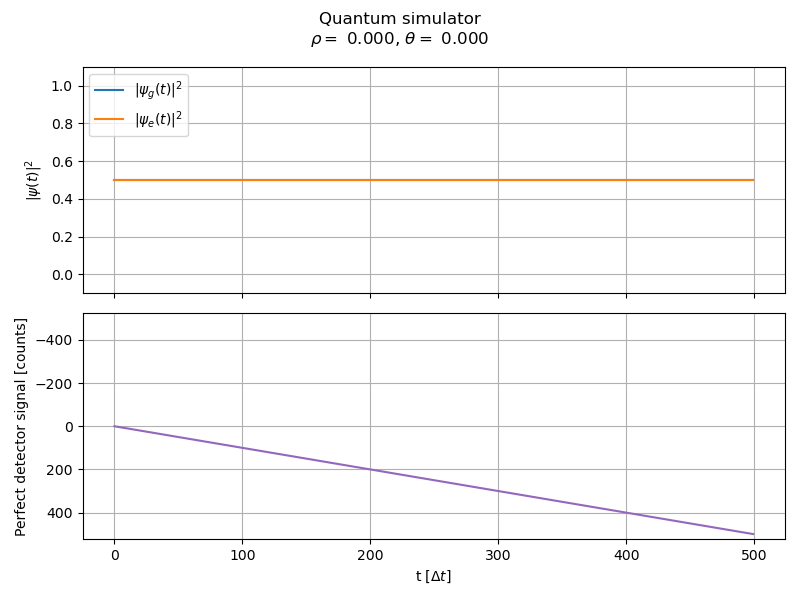

In [4]:
# Interactive plotting
fig, axs = subplots(ncols=1, nrows=2, figsize=(8, 6), sharex=True)

axs[0].set_ylabel("$|\psi (t)|^2$")
axs[0].set_ylim([-0.1, 1.1])
axs[1].set_ylabel("Perfect detector signal [counts]")
axs[1].set_xlabel(r"t [$\Delta t$]")

for i in range(2):
    axs[i].grid(True)

@interact(rho=(0, 0.5, 0.001), theta=(0, 1, 0.001)) 
def update_plot(
    rho: float = 0.0,
    theta: float = 0.0,
) -> None:
    
    for i in range(2):
        for line in axs[i].lines:
            line.remove()

    psi, ymeas = solve_trajectory(N_evol=500, theta=theta, rho=rho)

    # Plotting state populations
    psi_g_squared = absolute(psi[2, :]) ** 2 + absolute(psi[3, :]) ** 2
    psi_e_squared = absolute(psi[0, :]) ** 2 + absolute(psi[1, :]) ** 2
    axs[0].plot(psi_g_squared, color="C0", label=r"$ |\psi_g (t)|^2 $")
    axs[0].plot(psi_e_squared, color="C1", label=r"$ |\psi_e (t)|^2 $")
    axs[0].legend(loc="upper left")

    # Plotting the measured signal
    y_signal = cumsum(ymeas[2, :])
    axs[1].plot(y_signal, color="C4")
    axs[1].set_ylim(plot_bounds(y_signal))
    
    fig.suptitle(
        f"Quantum simulator\n"
        rf"$\rho = $ {rho:.3f}, $\theta = $ {theta:.3f}"
    )
    fig.tight_layout()
